<p style="font-family: Arial; font-size:2.8em;color:blue;"> Planes Detection </p>

# Computer Vision Final Project
## By Max Feldman , Yossi Saydon And Eddie Knazhinsky
### Holon Institute of technology - Summer 2019
<p style="font-family: Arial; font-size:1.2em;color:green;"> Dr . Jonathan Rubin </p>

<p style="font-family: Arial; font-size:1.2em;color:black;"> Before starting, our main goal was to try to create a dataset of planes and airlines logos and to check whether its possible to make a good detection of planes on a runway , to detect  what is the current airline that appears on the runway , to count how many planes took off and to know if the runway is clear for takeoff or it is currently occupied by another plane. </p>

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from timeit import default_timer as timer
import numpy as np
import random
import cv2 
from matplotlib import pyplot as plt
from glob import glob 
import time

<p style="font-family: Arial; font-size:1.2em;color:black;"> To be able to do it we will use Histogram of orianted gradients (HOG) , and we will train it with the required data </p>

In [2]:
def setHog(width, height ,size1,size2):
    winSize = (width,height)  # examples size are 36x36 pixels
    blockSize = (size1,size2)
    blockStride = (size1,size2)
    cellSize = (size2,size2)
    nbins = 20
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
    return hog

In [3]:
def create_descriptors(img_data_list,label,hog):
    descs = []
    img_ids_list = []
    for i in range(len(img_data_list)):
        descriptor = hog.compute(img_data_list[i])
        descs.append(np.asarray(descriptor, dtype=np.float32).flatten())
        img_ids_list.append(label)
    descs = np.array(descs,dtype=np.float32)
    
    return img_ids_list,descs

In [4]:
def data_concatenate_and_train(data_ids, data_desc, non_data_ids, non_data_desc):

    data = np.concatenate((non_data_desc, data_desc), axis=0)
    data = np.array(data, dtype=np.float32)

    labels = np.concatenate((non_data_ids, data_ids), axis=0)
    labels = np.array(labels, dtype=np.int32)

    svm = cv2.ml.SVM_create()

    svm.setType(cv2.ml.SVM_C_SVC)
    svm.setKernel(cv2.ml.SVM_LINEAR)
    svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 100, 1e-6))

    svm.train(data, cv2.ml.ROW_SAMPLE, labels);
    return svm

In [5]:
def create_moudle(hog,svm):
    sv = svm.getSupportVectors()
    rho,alpha,tmp = svm.getDecisionFunction(0)
    sv = np.append(-alpha*sv,rho)
    hog.setSVMDetector(sv)     
    return hog

In [6]:
def createHogSvm(data_list, non_data_list, width, height , size1,size2):
    hog = setHog(width, height,size1,size2)
    data_ids,data_desc = create_descriptors(data_list,1,hog)
    non_data_ids,non_data_desc = create_descriptors(non_data_list,-1,hog)
    svm = data_concatenate_and_train(data_ids, data_desc, non_data_ids, non_data_desc)
    final_hog = create_moudle(hog,svm)
    
    return final_hog     

In [7]:
def plot_samples(photo_array):    
    plt.figure(figsize=(12,10))
    for i in range (7):
        plt.subplot(1, 7, i+1)
        current_image=photo_array[i].reshape(photo_array[i].shape[0], photo_array[i].shape[1])
        plt.imshow(current_image, cmap='gray')
        plt.title("sample " +str(i+1))
        plt.axis('off')  

    plt.show()

<p style="font-family: Arial; font-size:1.2em;color:black;">
Before proceding ,since we didn't find a relavant dataset that is already available, we had to create our own dataset. we took 45 samples of different planes (horizontal - left to right) ,45 samples of different planes (horizontal - right to left) ,  30 samples of the rear side of the plane , 10 to 12 samples of each logo of an airliner , and 166 samples of random negative objects. </p>

num of left samples:  98


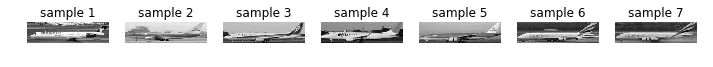

num of rear samples:  78


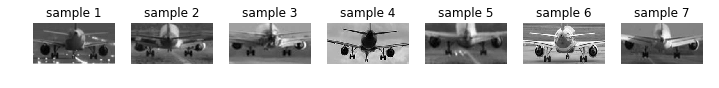

num of france samples:  12


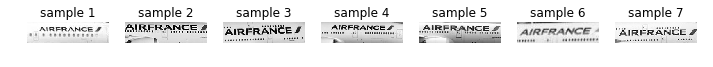

num of tap samples:  43


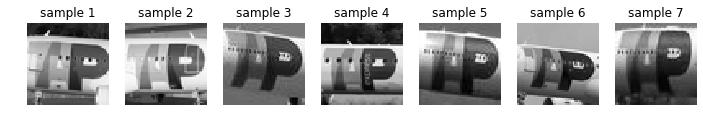

num of not_20050 samples:  590


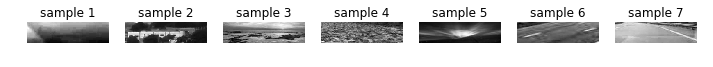

num of not_200100 samples:  382


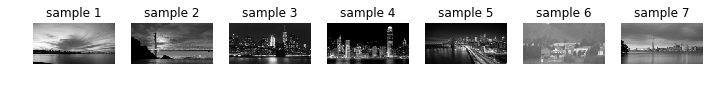

num of not_5050 samples:  590


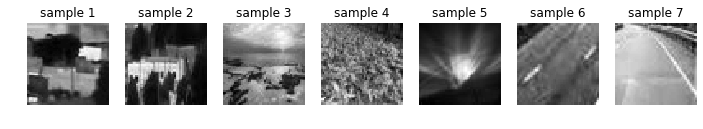

In [8]:
left = []
for path in glob("left/*.jpg"):
    img = cv2.imread(path,0)
    left.append(img)
    
print("num of left samples: ",len(left))
plot_samples(left)

#############################################################   
rear = []
for path in glob("rear/*.jpg"):
    img = cv2.imread(path,0)
    rear.append(img)   

print("num of rear samples: ",len(rear))    
plot_samples(rear)    

#############################################################
france = []
for path in glob("logos/france20050/*.jpg"):
    img = cv2.imread(path,0)
    france.append(img)
    
print("num of france samples: ",len(france))
plot_samples(france) 

############################################################
tap = []   
for path in glob("logos/tap/*.jpg"):
    img = cv2.imread(path,0)
    tap.append(img)
print("num of tap samples: ",len(tap))
plot_samples(tap) 

############################################################  
not_20050 = []
for path in glob("not_20050/*.jpg"):
    img = cv2.imread(path,0)
    not_20050.append(img)
    
print("num of not_20050 samples: ",len(not_20050))
plot_samples(not_20050) 

############################################################   
not_200100 = []
for path in glob("not_200100/*.jpg"): # cahange folder name to not_200100 later
    img = cv2.imread(path,0)
    not_200100.append(img)  
print("num of not_200100 samples: ",len(not_200100))
plot_samples(not_200100) 

############################################################    
not_5050 = []
for path in glob("not_50/*.jpg"):
    img = cv2.imread(path,0)
    not_5050.append(img) 
print("num of not_5050 samples: ",len(not_5050))
plot_samples(not_5050) 

In [9]:
def find_object(img,hogs_input,labels,th_list):
    img_rect = np.zeros_like(img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    glob_rects = []
    i_to_ret = -1
    offset = 10
    
    for i in range (len(hogs_input)):   
        rects, weights = hogs_input[i].detectMultiScale(img, winStride=(8,8), scale=1.03, hitThreshold=th_list[i], finalThreshold=2)
        
        if len(rects) > 0:
            i_to_ret = i
            for (x, y, w, h) in rects:
                
                x_bound_R = max(0,x-offset)
                x_bound_L = min(img.shape[1],x + offset)
                
                y_bound_R = max(0,y-offset)
                y_bound_L = min(img.shape[0],y + offset)
                
                x_sup_bound_R = max(0,x+w-offset)
                x_sup_bound_L = min(img.shape[1],x + w + offset)
                
                y_sup_bound_R = max(0,y+h-offset)
                y_sup_bound_L = min(img.shape[0],y + h + offset)
                
                
                x_bound_for_text = min(img.shape[1],(x + w)+20)
                cv2.rectangle(img_rect, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(img_rect,labels[i],(x_bound_for_text, (y + h)),font,0.7,(0,255,0),2,cv2.LINE_AA)
                
                
                cv2.line(img_rect,(x_bound_R, y_bound_R),(x_bound_L, y_bound_R),(0,255,0),2)
                cv2.line(img_rect,(x_bound_R, y_bound_R),(x_bound_R, y_bound_L),(0,255,0),2)

                cv2.line(img_rect,(x_sup_bound_L, y_bound_L),(x_sup_bound_L, y_bound_R),(0,255,0),2)
                cv2.line(img_rect,(x_sup_bound_L, y_bound_R),(x_sup_bound_R, y_bound_R),(0,255,0),2)


                cv2.line(img_rect,(x_bound_R, y_sup_bound_L),(x_bound_R, y_sup_bound_R),(0,255,0),2)
                cv2.line(img_rect,(x_bound_R, y_sup_bound_L),(x_bound_L, y_sup_bound_L),(0,255,0),2)

                cv2.line(img_rect,(x_sup_bound_L, y_sup_bound_L),(x_sup_bound_L, y_sup_bound_R),(0,255,0),2)
                cv2.line(img_rect,(x_sup_bound_L, y_sup_bound_L),(x_sup_bound_R, y_sup_bound_L),(0,255,0),2)

        
        glob_rects.append(rects)    
    return img_rect, glob_rects, i_to_ret      

In [10]:
hog_left = createHogSvm(left, not_20050, width = 200 , height = 50 , size1 = 20 ,size2=10)
hog_rear = createHogSvm(rear, not_200100, width = 200 , height = 100 , size1 = 20,size2=10)

hogs = []
hogs.append(hog_left)
hogs.append(hog_rear)

labels = []
labels.append("left")
labels.append("rear")

th_list = []
th_list.append(0.999)
th_list.append(0.45)

In [11]:
hog_france = createHogSvm(france, not_20050, width = 200 , height = 50 , size1 = 20,size2=10)
hog_tap = createHogSvm(tap, not_5050, width = 50 , height = 50 , size1 =5,size2=5)

hogs_logos = []
logos_titles=[]
th_list_logos = []
###################################################### 
hogs_logos.append(hog_france) 
logos_titles.append("Air france")
th_list_logos.append(0.39) #air france
####################################################### 
hogs_logos.append(hog_tap)
logos_titles.append("TAP Air Portugal")
th_list_logos.append(0.6) # 0.99 scale 1.05 # tap

To be able to calculate whether the runway is clear for take off or not we used canny  edge detectoion algorithm in order to find the runway lines, after using canny algorithm we also used erosion to make the lines more thicker. the lines that we have found will later guide us and will help us to calculate if there is a plane that crossing the runway and therefore the runway is occupied by another plane

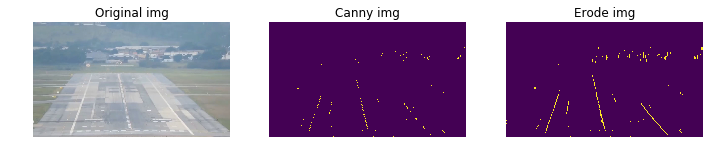

In [12]:
gx = np.array([[1,0,-1],
              [2,0,-2],
              [1,0,-1]])

plt.figure(figsize=(12,10))

road =  cv2.imread("clear_runway.JPG")
plt.subplot(1, 3, 1)
plt.title("Original img")
plt.axis('off')
plt.imshow(cv2.cvtColor(road,cv2.COLOR_BGR2RGB))


blur = cv2.GaussianBlur(road,(5,5),2)
img_gx = cv2.filter2D(blur,-1,gx)
canny = cv2.Canny(img_gx,5,200)

plt.subplot(1, 3, 2)
plt.title("Canny img")
plt.axis('off')
plt.imshow(canny)

dilat = cv2.dilate(canny,np.ones((5,5)),iterations = 2)
erod = cv2.erode(dilat,np.ones((5,5)),iterations = 2)

plt.subplot(1, 3, 3)
plt.title("Erode img")
plt.axis('off')
plt.imshow(erod)

plt.show()

In [13]:
def calculate_avg_coord(p0,p1,st):
    
    good_new = p1[st==1]
    good_old = p0[st==1]

    avg_x =0
    avg_y =0

    count =0
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        avg_x += (c-a)
        avg_y += (d-b)
        count += 1
        
    if(count != 0):
        avg_x = avg_x / count
        avg_y = avg_y / count
        
    return avg_x,avg_y # returns floats  

In our project we used Optical flow to be able to track certain key points of certain object on time “T” and then to check on time “T+1” if the current key points are same as the key points in the previous frame. If there is a match of “X” amount of key points in frame “T+1” but the detector didn’t recognized the object on “T+1” than we can assume that the object still appears.

In [14]:
def optical_flow(old_frame,new_frame,original_rect,big_rect):
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100, qualityLevel = 0.2, minDistance = 7,blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),maxLevel = 2,criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    (x,y,w,h) = original_rect[0] 
    x1,y1,w1,h1 = big_rect
    
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)[y:y+h,x:x+w]    
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    
    if p0 is not None:  # if p0 contains values so contniue the procces 
        frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)[y:y+h,x:x+w]    
        p1, st, err = cv2.calcOpticalFlowPyrLK(prevImg = old_gray, nextImg = frame_gray,
                                              prevPts = p0, nextPts = None, **lk_params) 

        if(sum(st) > 0.7*(len(st)) and len(st) > 7): # threshold 
            avg_x,avg_y = calculate_avg_coord(p0,p1,st)
            return True,avg_x,avg_y
        else:
            return False,0,0
            
    else: # if p0 not contains values we cant to contiue so return false
        return False,0,0

In [15]:
def func(old_frame,old_rects,new_frame,new_objects_rects,new_img_rects,area = 10):
    font = cv2.FONT_HERSHEY_SIMPLEX
 
    for i in range (len(old_rects)):
        for (x,y,w,h) in old_rects[i]:
            x1 = int(max(0,x-(area/2)))
            y1 = int(max(0,y-(area/2)))
            w1 = int(min(x+w+area,old_frame.shape[0]) - x)
            h1 = int(min(y+h+area,old_frame.shape[1]) - y)
            xx,yy,zz =  np.nonzero(new_img_rects[y1:y1+h1,x1:x1+w1])
            if(len(yy) == 0 ):
                ret,avg_x,avg_y = optical_flow(old_frame,new_frame,old_rects[i],(x1,y1,w1,h1))
                
                if(ret==True):
                    x_new = x-int(avg_x*1.3) # 1.1 is for fast transformation of the object
                    y_new = y-int(avg_y*1.3)
                    
                    x_new = max(0,x_new)
                    x_new = min(old_frame.shape[0],x_new)
                    
                    y_new = max(0,y_new)
                    y_new = min(old_frame.shape[1],y_new)
                                        
                    
                    cv2.rectangle(new_img_rects, (x, y), (x + w, y + h), (0, 255, 122), 2)
                    cv2.putText(new_img_rects,"optical flow",((x + w)+20, (y + h)),font,0.7,(0,255,0),2,cv2.LINE_AA)
                    if(len(new_objects_rects[i]) == 0):
                        new_objects_rects[i] = np.array( [[x_new,y_new,w,h]],dtype = np.int32)
                    else:
                        new_objects_rects[i] = np.vstack((new_objects_rects[i],[x_new,y_new,w,h]))
        
    return new_img_rects ,new_objects_rects            

In [24]:
def detect_take_off(test_img,rects,num_tookoff,flag,start,elapsed_time, found,companies_array,runway_clear) :

    font = cv2.FONT_HERSHEY_SIMPLEX
    a,b,c=test_img.shape
    line_y = int(a/4.5) 
    y_line = 0    
    text_thickness = 1
    text_size = 0.6
    text_size_logo = 0.5    
    text_offset =240

    mid_val = int(b/2)
    end = None
    
    for i in range (len(rects)):
        for (x,y,w,h) in rects[i]:
            if(y<line_y):
                if(flag==0):
                    flag=1
                    start=timer()
                    num_tookoff=num_tookoff+1
                    found = False
                else:
                    end = timer()
                    if(end-start > 10):
                        num_tookoff=num_tookoff+1
                        start=end
                        found = False
                    else:
                        start=end

    img_copy = test_img.copy()

    temp = np.zeros_like(test_img)
    pts = np.array([[0,0],[b,0],[b,line_y],[0,line_y]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(temp,[pts],True,(100,255,0))
    cv2.fillPoly(temp, [pts], (0,0,250))


    pts2 = np.array([[0,500],[b,0],[b,line_y],[0,line_y]], np.int32)
    pts2 = pts.reshape((-1,1,2))
    cv2.polylines(temp,[pts2],True,(100,255,0))
    cv2.fillPoly(temp, [pts2], (0,0,250))

    sum_airfrance = int(companies_array[0])
    sum_tap = int (companies_array[1])
    sum_other = int (num_tookoff - sum(companies_array) )
    
    txt_color = (255,255,255)

    cv2.putText(temp,'Air France: '+str(sum_airfrance),((0)+20,  (y_line+45)),font,text_size,txt_color,text_thickness,cv2.LINE_AA)
    cv2.putText(temp,'Tap Air Portugal: '+str(sum_tap),((0)+20,  (y_line+70)),font,text_size,txt_color,text_thickness,cv2.LINE_AA)
    cv2.putText(temp,'Other: '+str(sum_other),((0)+20,  (y_line+95)),font,text_size,txt_color,text_thickness,cv2.LINE_AA)
    
    cv2.putText(temp,'Planes took off: '+str(num_tookoff),((0)+300,  (y_line+40)),font,text_size+0.2,txt_color,text_thickness,cv2.LINE_AA)
    cv2.putText(temp,'Runway Clear for Takeoff: '+str(runway_clear),((0)+300,  (y_line+80)),font,text_size+0.2,txt_color,text_thickness,cv2.LINE_AA)
    
    cv2.putText(temp,'Time Elapsed: '+str(int(elapsed_time)),((0)+770,  (y_line+60)),font,text_size,txt_color,text_thickness,cv2.LINE_AA)
    #line separators
    
    cv2.line(temp,(text_offset+40,line_y),(text_offset+40,0),(0,255,0),1)   
    cv2.line(temp,(text_offset+500,line_y),(text_offset+500,0),(0,255,0),1)
    cv2.putText(temp,'Elapsed Time: '+str(int(elapsed_time)),(mid_val+text_offset*2, (int(line_y)-55)),font,text_size_logo-0.1,(0,255,0),text_thickness,cv2.LINE_AA)
        
    return temp,num_tookoff,flag,start,elapsed_time,found

In [17]:
def find_line(img,colors =(255,0,0)):
    
    gx = np.array([[1,0,-1],
              [2,0,-2],
              [1,0,-1]])
    
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 3  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 150  # minimum number of pixels making up a line
    max_line_gap = 2  # maximum gap in pixels between connectable line segments
    line_image = np.zeros_like(img)  # creating a blank to draw lines on
    
    blur = cv2.GaussianBlur(img,(7,7),1.5)
    img_gx = cv2.filter2D(blur,-1,gx)
    canny = cv2.Canny(img_gx,5,255)
    dilat = cv2.dilate(canny,np.ones((5,5)),iterations = 2)
    erod = cv2.erode(dilat,np.ones((5,5)),iterations = 2)
       
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(erod, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),colors,5)
    
    return line_image       

In [18]:
def find_logos(img,hogs_input,labels,th_list):
    y_up = int(img.shape[0] /1.4 )
    img_crop = img [ y_up : -1 , 0: -1]
    
    
    _,rects_crop, index_company_found = find_object(img_crop,hogs_input,labels,th_list)
    img_rect_of_crop = np.zeros_like(img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range (len(rects_crop)):        
        
        if len(rects_crop[i]) > 0:
            for (x, y, w, h) in rects_crop[i]:
                cv2.rectangle(img_rect_of_crop, (x, y +y_up), (x + w, y + y_up + h), (0, 255, 255), 2)
                cv2.putText(img_rect_of_crop,str(labels[i]),((x + w)+20, (y + y_up + h)),font,0.7,(0,255,0),2,cv2.LINE_AA)
   
    return img_rect_of_crop , index_company_found

In [19]:
def update_companies_detection(index_company,found_flag,companies_array):
    
    if(index_company != -1 and found_flag == False ):
        companies_array[index_company] = companies_array[index_company] + 1
        found_flag = True
    
    return found_flag, companies_array   

In [20]:
def is_runway_clear_for_takeoff(objects_rects):
    if(len(objects_rects[0]) > 0): # have left plane in fram
        return False
    else:
        return True

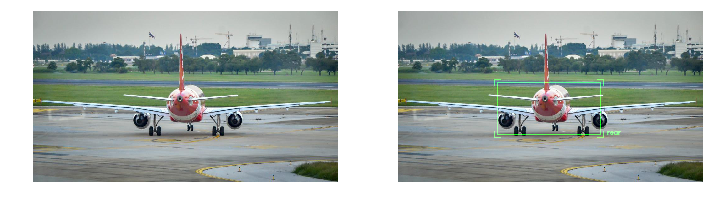

In [21]:
plane_rear =  cv2.imread("plane_takeOff.jpg")
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(plane_rear,cv2.COLOR_BGR2RGB))

img_rec,_ ,_ = find_object(plane_rear,[hog_rear],["rear"],[0.6])
plt.subplot(1,2,2)
plt.axis('off')
img_out = cv2.addWeighted(img_rec, 1, plane_rear, 1, 0);
plt.imshow(cv2.cvtColor(img_out,cv2.COLOR_BGR2RGB))

plt.show()

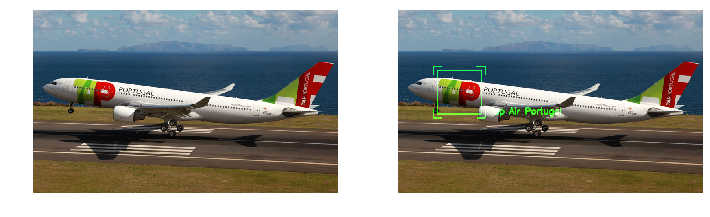

In [22]:
plane_rear =  cv2.imread("TAP_plane.jpg")
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(plane_rear,cv2.COLOR_BGR2RGB))

img_rec,_ ,_ = find_object(plane_rear,[hog_tap],["Tap Air Portugal"],[0.6])
plt.subplot(1,2,2)
plt.axis('off')
img_out = cv2.addWeighted(img_rec, 1, plane_rear, 1, 0);
plt.imshow(cv2.cvtColor(img_out,cv2.COLOR_BGR2RGB))

plt.show()

After successfully configuring the HOG Detecors with different hyper parameters, we have trained our detectors using SVM (Support Vector Machine) . The next step was to try calculate how many planes took off from the runway, to be able to do it we have assigned a line that will play a role of “border” between the area where the planes are preparing for take off and the area that the planes are already flying. Each time a plane was detected, the detector will assign a rectangle around the plane and we will use the rectangle Cartesian coordinates to calculate whether the rectangle is above the border line or below the line , if the rectangle has crossed the line we increment the value of the planes counter by one.

In [25]:
cap = cv2.VideoCapture('Vid2New.mp4')

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('Result.mp4',fourcc,20.0,(960,540),3)

ret, old_frame = cap.read()

old_img_rects ,old_objects_rects,_ = find_object(old_frame,hogs,labels,th_list)

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

num_tookoff=0

flag = 0
start = None

start_time = time.time()

found_logo = False
companies = np.zeros(2)

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==False:
        break
        
    try:
        img_logos,index_company = find_logos(frame,hogs_logos,logos_titles,th_list_logos)
        found_logo, companies = update_companies_detection(index_company,found_logo,
                                                           companies)

        elapsed_time = time.time() - start_time   
        img_rects ,objects_rects,_ = find_object(frame,hogs,labels,th_list)
        img_rects, objects_rects = func(old_frame,old_objects_rects,frame,objects_rects,img_rects)
        
        runway_clear = is_runway_clear_for_takeoff(objects_rects)

        info,num_tookoff,flag,start,elapsed_time,found_logo = detect_take_off(frame,
                                                                            objects_rects,
                                                                            num_tookoff,
                                                                            flag,start,
                                                                            elapsed_time,
                                                                            found_logo,
                                                                            companies,runway_clear)
        
        if(runway_clear):
            img_lines = find_line(frame,(0,255,0)) 
        else:
            img_lines = find_line(frame,(0,0,255))

        img = cv2.addWeighted(img_rects, 0.4, frame, 1, 0);
        img = cv2.addWeighted(info, 0.4, img, 1, 0);
        img = cv2.addWeighted(img_lines, 1, img, 0.9, 0);
        img = cv2.addWeighted(img_logos, 1, img, 0.9, 0);

        cv2.imshow('my video',img)
        video.write(img)

        old_frame, old_objects_rects  = frame, objects_rects #update

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    except:
        print("was error")
        break

cap.release()
video.release()
cv2.destroyAllWindows()